In [5]:
import torch
import numpy as np
import cv2
import best.singular_point as sp
from teste_util import *
import teste_util as TS

# Fixar a semente do Torch para operações específicas
fixed_seed()

# leitura dos dados
trainloader,testloader =read_dataload_flower(sp.args.img_size,'./data/datasets',batch_size=60)
# trainloader,testloader =read_dataload_fibers(sp.args.img_size)
# trainloader,testloader=read_dataload_woods(sp.args.img_size)
iterator=iter(testloader)
img,labels = next(iterator)
print(img.shape)

# Carregar o modelo singular points
path_siamese = './data/models/sp_map_fo_30.pth'
sp.args.num_channels = 1
print(sp.args)
model = sp.SingularPoints(args=sp.args).to(sp.device)
load_model(model,path_siamese,sp.device)

#gerar variacao de transformacoes pespectivas e fotometrica
params_lists =AugmentationParamsGenerator(6,img.shape)


torch.Size([60, 1, 120, 120])
Namespace(exported=False, num_channels=1, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)
Namespace(exported=False, num_channels=1, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)
Model loaded from ./data/models/sp_map_fo_30.pth


/home/wagner/Documentos/python/singular-points2/teste_util.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath,map_location=device

### CustonNetDetector

In [2]:


def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius
    return mask
 
from torch import nn
class Detector(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key_summary
        
class Detector2(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key
        
from external.hardnet_pytorch import HardNet        
class Descriptor(nn.Module):
        def __init__(self) -> None:
           super().__init__()           
           hardnet = HardNet()
           checkpoint = torch.load('trained_models/pretrained_nets/HardNet++.pth')
           hardnet.load_state_dict(checkpoint['state_dict'])
           hardnet.eval()
           hardnet.to(sp.device) 
           self.model = hardnet
        def forward(self, x):
           return self.model(x)



detec = Detector(model)
detec2 = Detector2(model)
desc = Descriptor()

keynet_default_config = {#
    'num_filters': 8,
    'num_levels': 3,
    'kernel_size': 5,
    # 'Detector_conf': {'nms_size': 9, 'pyramid_levels': 2, 'up_levels': 2, 'scale_factor_levels': 1.5, 's_mult': 14.0},
    # 'Detector_conf': {'nms_size': 5, 'pyramid_levels': 3, 'up_levels': 2, 'scale_factor_levels': 1.3, 's_mult': 12.0},
    'Detector_conf': {'nms_size': 5, 'pyramid_levels': 3, 'up_levels': 2, 'scale_factor_levels': 1.3, 's_mult': 12.0},
    # 'Detector_conf': {'nms_size': 5, 'pyramid_levels': 2, 'up_levels': 1, 'scale_factor_levels': 1.2, 's_mult': 19.0}, #1006/1020 - 0.986
    # 'Detector_conf': {'nms_size': 7, 'pyramid_levels': 2, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 19.0},#fibers 159/220 - 0.722
    # 'Detector_conf': {'nms_size': 15, 'pyramid_levels': 2, 'up_levels': 1, 'scale_factor_levels': 1.2, 's_mult': 22.0},#woods 393/496 0
}

TS.PS=32
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(sp.device)
descriptor = desc#sift
detector = CustomNetDetector(detec,PS=TS.PS,keynet_conf=keynet_default_config,num_features=60).to(sp.device)

/tmp/ipykernel_841227/74163730.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('trained_models/pretrained_nets/HardNet++.pth')


In [3]:
def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        map = detec2(image[None])
        # print('map ',map.shape,image[None].shape)
        patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, 32)
        B, N, CH, H, W = patches.size()
        # print('patches  ',patches.shape)
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        # print('descs  ',descs.shape)
        return lafs, descs

def detect_extract_feat_in_batch(batch_img, detector, descriptor, PS):
    repo_lafs_desc = []
    with torch.no_grad():
        for image  in batch_img:
            
            lafs, resps = detector(image[None])
            patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, 32)

            B, N, CH, H, W = patches.size()
            descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
            repo_lafs_desc.append((lafs,descs))
    return repo_lafs_desc

def matching_imagens(ref_img,batch_img, repo_lafs_desc):
    best_match_info = None
    best_match_count = 0
    best_match_index = None
    with torch.no_grad():
        # Detectar e extrair características da imagem de referência
        lafs_ref, descs_ref = detect_and_extract_features(ref_img, detector, descriptor, PS)
        
        for i, (lafs_i, descs_i) in enumerate(repo_lafs_desc):
            # Detectar e extrair características da imagem atual do batch
            # lafs_i, descs_i = detect_and_extract_features(img, detector, descriptor, PS)
            # Comparar as características da imagem de referência com a imagem atual do batch
            scores, matches = kornia.feature.match_snn(descs_ref[0], descs_i[0], 0.85) # correspondencia dos descritories a uma distância de 0.9

            if matches.shape[0] >= 4:
                # Cálculo da homografia
                inliers_mask = compute_homography(lafs_ref, lafs_i, matches)
                # print(lafs_ref[0][None].shape, lafs_ref[0].shape, matches.shape, inliers_mask.shape)

                # Check if this match is better than the previous best match
                if matches.shape[0] > best_match_count:
                    best_match_info = (lafs_ref[0][None].cpu(), lafs_i[0][None].cpu(), matches.cpu(),
                                       kornia.tensor_to_image(ref_img.cpu()), kornia.tensor_to_image(batch_img[i].cpu()),
                                       inliers_mask)
                    best_match_count = matches.shape[0]
                    best_match_index = i

        if best_match_info is not None and best_match_index==0:# TODO: Remove this condition best_match_index==0
            # Plot the best match
            from kornia_moons.viz import draw_LAF_matches

            draw_LAF_matches(
                *best_match_info,
                draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
            )
        # else:
        #     print("No matches found with enough inliers.")
    return best_match_index


  0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: 

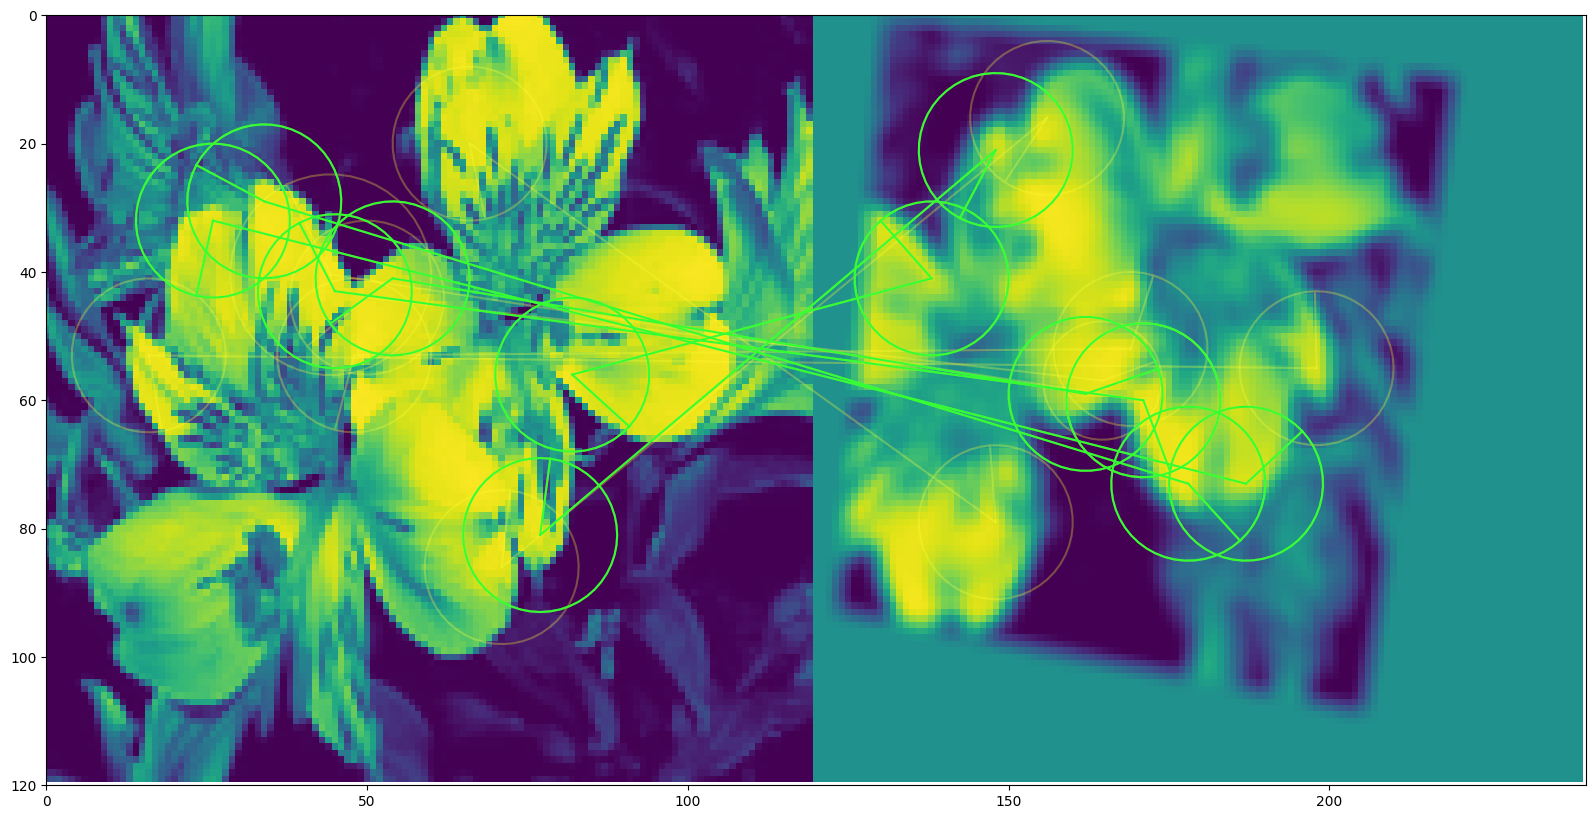

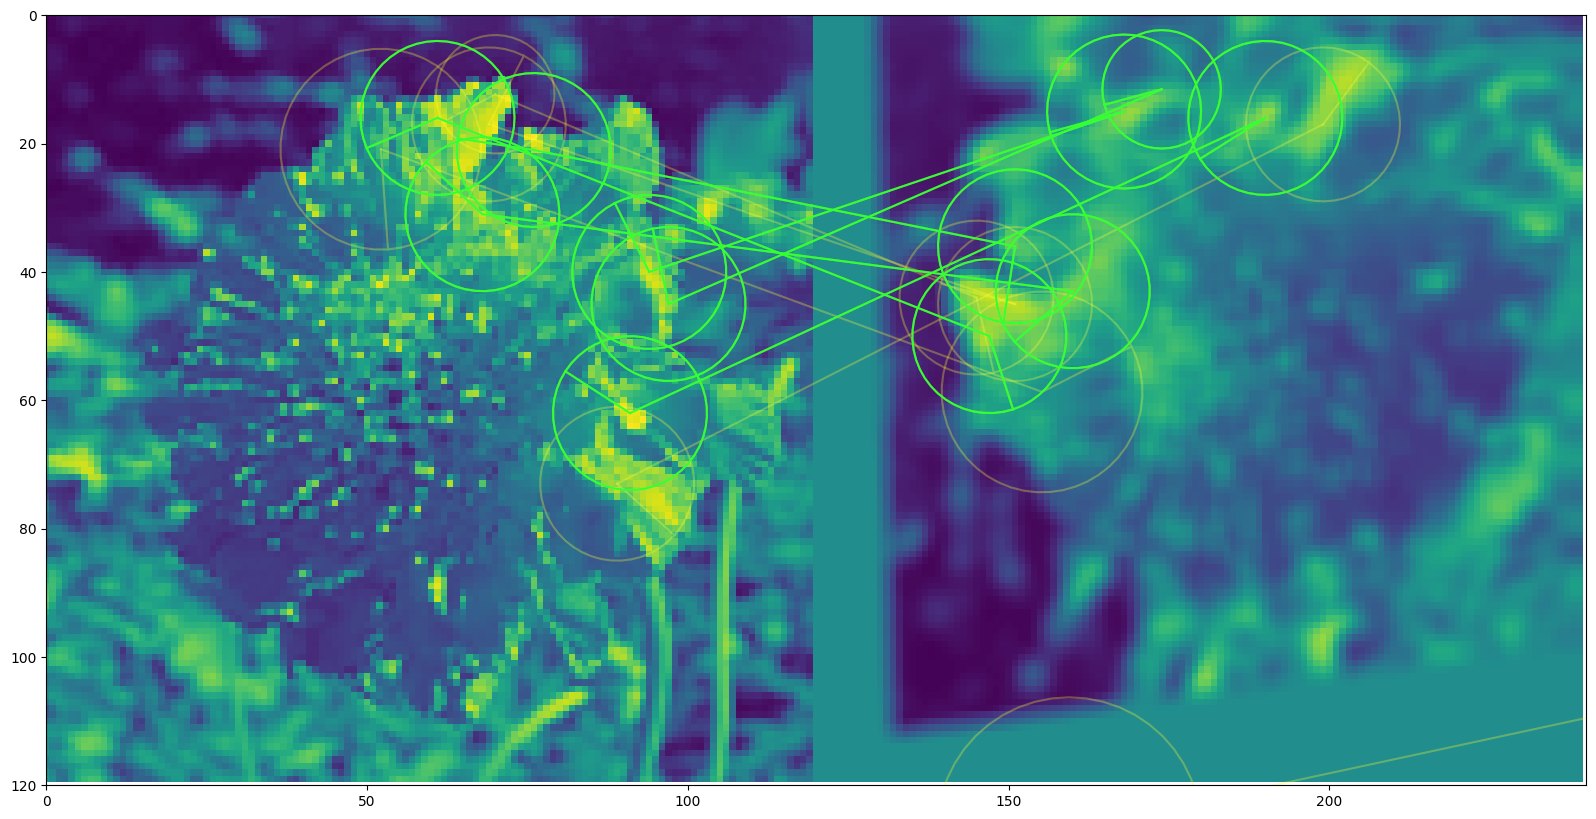

In [4]:
params_lists.aug_list.data_keys =["input"]
aug_list = params_lists.aug_list

acertos = 0
total = 0
from tqdm.notebook import tqdm
pbar =  tqdm(testloader)
for imgs_batch,labels_batch in pbar:# itera em todo dataset
    imgs_batch = imgs_batch.to(sp.device)
    
    params_item = next(params_lists)
    timg_gray_t = aug_list(imgs_batch,params=params_item)
    repo_lafs_desc= detect_extract_feat_in_batch(timg_gray_t,detector,descriptor,TS.PS)
        
    for i,img_gray in enumerate(imgs_batch):# itera em cada batch

        match_index = matching_imagens(img_gray,timg_gray_t,repo_lafs_desc)
        # print("match_index: ",match_index," i: ",i)
        total+=1
        if match_index == i:
            acertos += 1
        pbar.set_description(f"acertos/total: {acertos}/{total}  ")
print("acertos: ",acertos)